# Tutorial: Full dynamics with Qmeq
#### Author: Stephanie Matern

This tutorial explains how to extract the full dynamics of a system using Qmeq. 

## Introduction 
This short introduction briefly explaines the spectral decompostion of the Liouvillian.

Generally, the dynamics of the system are governed by
\begin{align}
    \dot{\rho} = \mathcal{L}\rho,
\end{align}
with the Liouville (super)operator
\begin{align} 
    \mathcal{L}[(\cdot)] = -i \left[H_\text{eff},(\cdot)\right] + \mathcal{D}[(\cdot)].
\end{align}

Here, $H_\text{eff}$ is the (effective) system Hamiltonian and $\mathcal{D}$ captures the system's dissipation. Adopting a superoperator notation, the Liouvillian can be represented by a matrix, $\mathcal{L} \to \hat{L}$, which then acts on the vectorized density matrix $\lvert\rho)$
\begin{align}
    \frac{d}{dt} \lvert \rho) = \hat{L}\lvert\rho).
\end{align}
The full time evolution of $ \lvert \rho)$ is then given by the solution of
\begin{align}
     \lvert \rho(t)) = e^{\hat{L} t} \vert \rho(0)),
\end{align}
with the initial state $\vert \rho(0))$ at $t = 0$.
In terms of the spectral decompostion of $\hat{L}$ (of dim $N\times N$) the solution can be written as
\begin{align}
     \lvert \rho) = \vert \rho_\text{ss}) + \sum_{j = 2}^N\, e^{\lambda_j t} (l_j \rvert \rho(0)) \lvert r_j).
\end{align}
The (sorted) eigenvalues $\lambda_j$ belong the left  $(l_j \rvert$ and right  $\vert r_j)$ eigenvectors of $\hat{L}$, i.e.,
\begin{align}
    \hat{L} \vert r_j) = \lambda_j \vert r_j) \\
    (l_j\vert \hat{L} = \lambda_j  (l_j\vert.
\end{align}
The eigenvectors are chosen such that they fulfill
\begin{align}
    (l_j\vert r_k) = \delta_{jk}
    \label{eq:normalization}
\end{align}
[This can be done by calculating the right eigenvectors and contructing the left ones].
The eigenvalues $\lambda_1 = 0$ indicates the stationary state with
the stationary state density matrix given by
\begin{align}
    \vert \rho_\text{ss}) =  \frac{(l_0\vert \rho(0))}{(l_0\vert r_0)}\vert r_0)
\end{align}
    Note that we are assuming here that a single, unique stationary state exists. In fact, $ (l_0\vert$ corresponds to the identity if the normalization is chosen correctly.
    
All other $\lambda_j$ have a negative real part for a physical sensible decay. 


Note: Strictly speaking, the spectral decomposition is only possible for a positive, trace preserving evolution. This is from a pure mathematically only proved for a Lindblad dissipation. However, it also seems to work for the other approaches in Qmeq. Nevertheless, it is crucial to check if the evolution is physical, i.e., all eigenvalues have negative real part. 



## Qmeq implementation 

As an example system we will use the Anderson model, a single level, 
spin-full quantum dot coupled to two leads (left - L and right - R), defined in the following.

In [1]:
# import necessary packages
import sys
sys.path.append('qmeq/')
import qmeq

from scipy.linalg import eig, eigvals
import numpy as np

import matplotlib.pyplot as plt

In [2]:
# Anderson dot model (from qmeq tutorial)

# Quantum dot parameters
vgate = 0.0
bfield = 0.001
omega = .1
U = 20.0


# Lead parameters
vbias = 0.5
temp = 1.0
dband = 100.0
# Tunneling amplitudes
gam = 0.5
t0 = np.sqrt(gam/(2*np.pi))

nsingle = 2

# 0 is up, 1 is down
hsingle = {(0, 0): vgate+bfield/2,
           (1, 1): vgate-bfield/2,
           (0, 1): omega}

coulomb = {(0,1,1,0):U}

tleads = {(0, 0):t0, # L, up   <-- up
          (1, 0):t0, # R, up   <-- up
          (2, 1): 2 * t0, # L, down <-- down         
          (3, 1): 2* t0} # R, down <-- down
                     # lead label, lead spin <-- level spin

nleads = 4

#        L,up        R,up         L,down      R,down
mulst = {0: vbias/2, 1: -vbias/2, 2: vbias/2, 3: -vbias/2}
tlst =  {0: temp,    1: temp,     2: temp,    3: temp}



sys = qmeq.Builder(nsingle, hsingle, coulomb,
                      nleads, tleads, mulst, tlst, dband, countingleads = [0,2],
                      kerntype='py1vN', itype = 1)

# make sure the kernel does not get overwritten
sys.make_kern_copy = True

sys.solve()


Qmeq constructs the Liouvillan (kernel) when solving for the stationary state. The kernel is accessible via sys.kern, which for the Anderson model is a $6\times 6$ matrix. 

In [3]:
liouvillian = sys.kern
print(liouvillian.shape)
# print(liouvillian)


(6, 6)


To solve for the full time evolution, we need to find the left and right eigenvectors of the Liouvillian.

In [4]:
# calculate eigenvalues, left and right eigenvalues
eval_j, left_ev, right_ev = eig(liouvillian, left = True) 

# sort eigenvalues/eigenvectors
idx = eval_j.argsort()[::-1]   
eval_j = eval_j[idx]
left_ev = left_ev[:,idx]
right_ev = right_ev[:,idx] 

For consistency, we can also check the normalization $(l_j^\dagger\vert r_k) = \delta_{jk}$.

In [5]:
result = np.zeros((6,6)) + 0j

for j in range(6):
    for k in range(6):
        result[j,k] = np.dot(np.conjugate(left_ev[:,j]),right_ev[:,k])
        # normalization to 1
        if j == k:
            result[j,k] = result[j,k]/np.dot(np.conjugate(left_ev[:,j]),right_ev[:,k])
            
print(str(np.round(np.real(result),1)))

[[ 1.  0.  0.  0.  0. -0.]
 [ 0.  1. -0. -0. -0.  0.]
 [ 0. -0.  1.  0.  0.  0.]
 [ 0. -0.  0.  1.  0.  0.]
 [ 0. -0. -0. -0.  1. -0.]
 [ 0. -0.  0.  0.  0.  1.]]


We can also verify that $(l_1\vert$ corresponds to the identity operator,  $(l_1\vert$ not normalized so factor of 2 is added).

In [6]:
np.real(np.round(2 * left_ev[:,0],0))

array([1., 1., 1., 1., 0., 0.])

### Stationary state

The stationary state can be directly calculated from the first left and right eigenvectors. It has to correspond to the qmeq solution (sys.phi0).

In [7]:
# definie initial state
initial = np.array([1,0,0,0,0,0])

# calculate stationary state from left/right eigenvectors
rho_ss = 1/np.dot((left_ev[:,0]),right_ev[:,0]) * np.dot(np.conjugate(left_ev[:,0]), initial) * right_ev[:,0]


print('rho_ss from left/right eigenvectors: \n' + str(rho_ss))
print(' \n qmeq solution rho_ss: \n' + str(sys.phi0))
print(' \n difference: ' + str(np.round(sys.phi0 - rho_ss,10).real) )


rho_ss from left/right eigenvectors: 
[ 3.34519464e-01+0.j  3.46476800e-01+0.j  3.18988119e-01+0.j
  1.56170598e-05+0.j -4.20054452e-03+0.j  1.62122212e-02+0.j]
 
 qmeq solution rho_ss: 
[ 3.34519464e-01  3.46476800e-01  3.18988119e-01  1.56170598e-05
 -4.20054452e-03  1.62122212e-02]
 
 difference: [ 0.  0.  0.  0. -0. -0.]


### Full time evolution -- Density matrix
We can now just calculate the full time evolution of the density matrix according to

\begin{align}
 \lvert \rho(t)) = \vert \rho_\text{ss}) + \sum_{j = 2}^N\, e^{\lambda_j t} (l_j \rvert \rho(0)) \lvert r_j).
 \end{align}

In [8]:
# define time grid
ti_array = np.linspace(0,10,500)

#dimension
dim = liouvillian.shape[0]

rho_t = np.zeros((dim,ti_array.shape[0])) + 0j

# calculate elements and perform sum
for i in range(dim-1):
    norm = np.dot(np.conjugate(left_ev[:,i+1]),right_ev[:,i+1])
    rho_t += 1/norm * np.dot(np.conjugate(left_ev[:,i+1]), initial) * np.exp(eval_j[i+1] *  ti_array[None,:]) * right_ev[:,i+1,None] 

#add stationary state    
rho_t = rho_t + rho_ss[:,None]

print(rho_t.shape)

(6, 500)


#### Evolution of diagonal components 

Text(0, 0.5, '$\\rho(t)$')

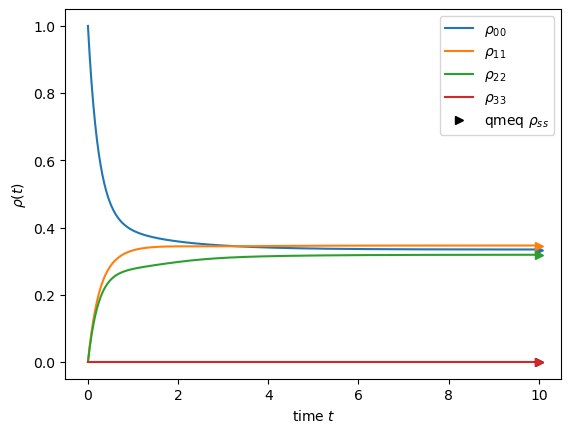

In [9]:
plt.plot(ti_array, np.real(rho_t[0]), label = r'$\rho_{00}$')
plt.plot(ti_array[-1],sys.phi0[0], '>',color = 'C0')

plt.plot(ti_array, np.real(rho_t[1]), label = r'$\rho_{11}$')
plt.plot(ti_array[-1],sys.phi0[1], '>',color = 'C1')


plt.plot(ti_array, np.real(rho_t[2]), label = r'$\rho_{22}$')
plt.plot(ti_array[-1],sys.phi0[2], '>',color = 'C2')



plt.plot(ti_array, np.real(rho_t[3]), label = r'$\rho_{33}$')
plt.plot(ti_array[-1],sys.phi0[3], '>',color = 'black', label = r'qmeq $\rho_{ss}$')
plt.plot(ti_array[-1],sys.phi0[3], '>',color = 'C3')

plt.legend()

plt.xlabel(r'time $t$')
plt.ylabel(r'$\rho(t)$')




#### Evolution of off-diagonal components 

Text(0, 0.5, '$\\rho(t)$')

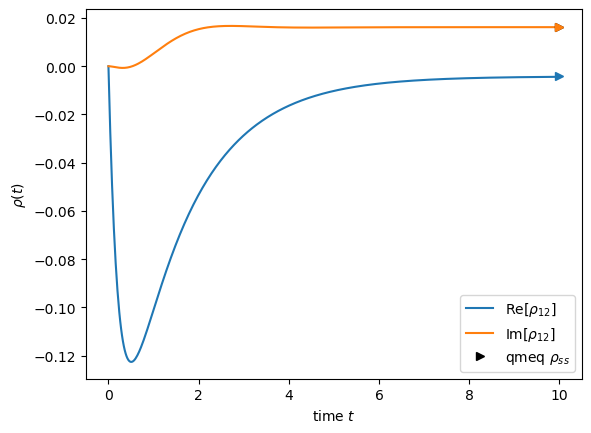

In [10]:
plt.plot(ti_array, np.real(rho_t[4]), label = r'Re[$\rho_{12}$]')
plt.plot(ti_array[-1],sys.phi0[4], '>',color = 'C0')



plt.plot(ti_array, np.real(rho_t[5]), label = r'Im[$\rho_{12}$]')
plt.plot(ti_array[-1],sys.phi0[5], '>',color = 'black', label = r'qmeq $\rho_{ss}$')
plt.plot(ti_array[-1],sys.phi0[5], '>',color = 'C1')

plt.legend()

plt.xlabel(r'time $t$')
plt.ylabel(r'$\rho(t)$')




### Full time evolution -- particle current
Below we calculate the particle current via two different ways: (i) using 'original' qmeq functions
(ii) using Simon's qmeq addition with counting fields (CF)

In [15]:
# transient current

# qmeq solution for stationary current 
I_ss = sys.current

I_t_qmeq = np.zeros((nleads,ti_array.shape[0]))
I_t_CF = np.zeros((ti_array.shape[0]))


for i in range(ti_array.shape[0]):
    
    # reset current    
    sys.current[:] = np.zeros(nleads)
    
    # set stationary state to rho_t value
    sys.phi0[:] = np.real(rho_t[:,i])
    
    # calculate current (also calculates energy and heat currents)
    sys.appr.generate_current() # calculates current both ways
    I_t_qmeq[:,i] = sys.current
    I_t_CF[i] = sys.current_noise[0] 
    
    #--------------------------------------------
    
# combine contributions from left and right lead    
IL_t_qmeq = I_t_qmeq[0] + I_t_qmeq[2]
IR_t_qmeq = I_t_qmeq[1] + I_t_qmeq[3]

Text(0, 0.5, '$I(t)$')

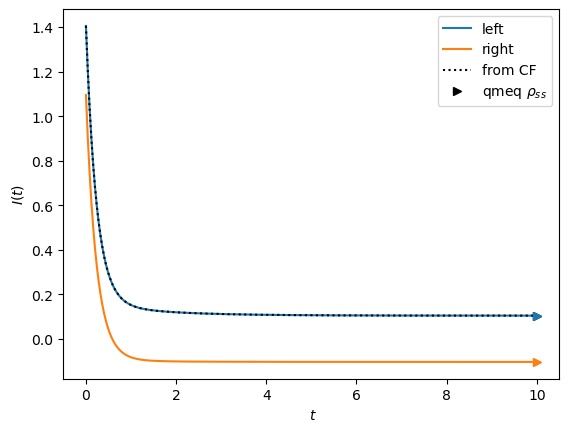

In [16]:
plt.plot(ti_array,IL_t_qmeq , label = 'left')
plt.plot(ti_array, IR_t_qmeq ,label = 'right')
plt.plot(ti_array[-1], (I_ss[1] + I_ss[3]), '>', color = 'C1' , )

plt.plot(ti_array, I_t_CF, ':', color = 'black', label = r'from CF')

plt.plot(ti_array[-1], I_ss[0] + I_ss[2],'>',color = 'black', label = r'qmeq $\rho_{ss}$')
plt.plot(ti_array[-1], I_ss[0] + I_ss[2], '>', color = 'C0', )

plt.legend()

plt.xlabel(r' $t$')
plt.ylabel(r'$I(t)$')